In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the Data
Importing all the necessary libraries required to run the following code for image colourization.

In [2]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray

Defining the directory for the dataset to be used. The dataset used here is a small 6 GB snippet of the ImageNet dataset. It has 2 classes: 'train' and 'val', containing 45000 and 5000 images respectively.

In [3]:
DATA_DIR = '../input/imagenet/imagenet/'

Loading images contained in the data directory into a avriable called dataset using ImageFolder, and applying two transforms to all the images:
1. Resizing the non-uniformly sized images into 256x256 images.
2. Converting them into tensors.

In [4]:
dataset = ImageFolder(DATA_DIR, transform=T.Compose([T.Resize((256, 256)),T.ToTensor()]))

As mentioned above, the dataset has a total 50000 images.

In [5]:
len(dataset)

50000

Creating the training and validation sets. A seed 42 is set to have the same training and validation datasets each time the notebook is run, and the two datasets are split using the random_split function from the pytorch libraries.

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

val_size = 1000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(49000, 1000)

The batch size is set to be 128.

In [7]:
batch_size = 128

Loading the training and validation datasets into the CPU using DataLoader.

In [8]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, num_workers = 4, pin_memory = True)

Make cuda(GPU) the device if availability permits.

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

Define a function to load data into the device assigned above.

In [10]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

Define a class to load data into a GPU, if it's available, otherwise into a CPU.

In [11]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
  
    def __len__(self):
        return len(self.dl)

Since we are using a GPU, load the training and validation datasets into cuda(the selected device).

In [12]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

# Defining the Model
The images are originally using the RGB colormodel. But for the purpose of image colourization, they have to be converted to Lab. The CIELAB is a colorspace which has 3 channels: L, a, and b. The function defined below converts images from RGB to CIELAB, and then splits the L and ab channels into the variables X and Y respectively. The range of ab channels is from -128 to 127, hence, the ab channels are normalized by dividing it by 128. The function returns finally returns X and Y loaded into cuda.

In [13]:
def generate_l_ab(images): 
    lab = rgb2lab(images.permute(0, 2, 3, 1).cpu().numpy())
    X = lab[:,:,:,0]
    X = X.reshape(X.shape+(1,))
    Y = lab[:,:,:,1:] / 128
    return to_device(torch.tensor(X, dtype = torch.float).permute(0, 3, 1, 2), device),to_device(torch.tensor(Y, dtype = torch.float).permute(0, 3, 1, 2), device)

The Base Model class is defined as containing three functions. 
1. The *training_batch* function takes the batch of 128 images as input, generates the values of L and ab channels using the *generate_l_ab* function, gets the predicted ab channels using the forward function of the model, and calculates the MSE Loss between the actual and predicted ab channels.
2. The *validation_batch* functions performs the same task as the *training_batch* function, except for the images in the validation dataset, which is evident from the function names.
3. The function *validation_end_epoch* returns the average loss on the validation dataset.

In [14]:
class BaseModel(nn.Module):
    def training_batch(self, batch):
        images, _ = batch
        X, Y = generate_l_ab(images)
        outputs = self.forward(X)
        loss = F.mse_loss(outputs, Y)
        return loss

    def validation_batch(self, batch):
        images, _ = batch
        X, Y = generate_l_ab(images)
        outputs = self.forward(X)
        loss = F.mse_loss(outputs, Y)
        return {'val_loss' : loss.item()}

    def validation_end_epoch(self, outputs):
        epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
        return {'epoch_loss' : epoch_loss}

A helper function is defined to get the appropriate padding in order to keep the size of the output image same as the input image during convolution.

In [15]:
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding

The *Encoder_Decoder* class is an extension of the Base Model and it contains the code for the architecture of the model.

In [16]:
class Encoder_Decoder(BaseModel):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 3, stride = 2, padding = get_padding(3, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size = 3, padding = get_padding(3)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        
            nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = get_padding(3, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size = 3, padding = get_padding(3)),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        
            nn.Conv2d(256, 256, kernel_size = 3, stride = 2, padding = get_padding(3, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size = 3, padding = get_padding(3)),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(512, 512, kernel_size = 3, padding = get_padding(3)),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size = 3, padding = get_padding(3)),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        
            nn.Conv2d(256, 128, kernel_size = 3, padding = get_padding(3)),
            nn.Upsample(size = (64,64)),
            nn.Conv2d(128, 64, kernel_size = 3, padding = get_padding(3)),
            nn.Upsample(size = (128,128)),
            nn.Conv2d(64, 32, kernel_size = 3, padding = get_padding(3)),
            nn.Conv2d(32, 16, kernel_size = 3, padding = get_padding(3)),
            nn.Conv2d(16, 2, kernel_size = 3, padding = get_padding(3)),
            nn.Tanh(),
            nn.Upsample(size = (256,256))
    )

    def forward(self, images):
        return self.network(images)     
    

The model is defined and loaded to cuda.

In [17]:
model = Encoder_Decoder()
to_device(model, device)

Encoder_Decoder(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 512, kernel_size=(3, 

# Training the Model
The *validate* and *fit* functions are defined to keep track of the loss and train the model.

In [18]:
@torch.no_grad()
def validate(model, val_loader):
    model.eval()
    outputs = [model.validation_batch(batch) for batch in val_loader]
    return model.validation_end_epoch(outputs)

def fit(model, epochs, learning_rate, train_loader, val_loader, optimization_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = optimization_func(model.parameters(), learning_rate)
    for epoch in range(epochs):
        train_losses = []
        model.train()
        for batch in tqdm(train_loader):
            loss = model.training_batch(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = validate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        history.append(result)
        print('Epoch: {}, Train loss: {:.4f}, Validation loss: {:.4f}'.format(epoch, result['train_loss'], result['epoch_loss']))
    return history

Initializing the loss.

In [19]:
history = [validate(model, val_loader)]
history

[{'epoch_loss': 0.01800026441924274}]

Training.

In [20]:
history += fit(model, 5, 0.001, train_loader, val_loader, torch.optim.Adam)


Epoch: 0, Train loss: 0.0148, Validation loss: 0.0150



Epoch: 1, Train loss: 0.0140, Validation loss: 0.0134



Epoch: 2, Train loss: 0.0139, Validation loss: 0.0132



Epoch: 3, Train loss: 0.0138, Validation loss: 0.0133



Epoch: 4, Train loss: 0.0138, Validation loss: 0.0132


Saving the model to be able to continue training the model from the same point.

In [21]:
checkpoint = {'model': Encoder_Decoder(),
              'state_dict': model.state_dict()}

In [22]:
torch.save(checkpoint, 'test.pth')

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder_Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loading the pth file to continue training from the same parameters onwards.

In [23]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = True
    
    model.eval()
    
    return model

In [24]:
model = load_checkpoint('../input/testing/test21.pth')
print(model)
to_device(model, device)

Encoder_Decoder(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 512, kernel_size=(3, 

Encoder_Decoder(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 512, kernel_size=(3, 

# Testing the Model
Combining the L channel and the predicted ab channels and converting it to RGB to obtain the final colour image.

In [25]:
def to_rgb(grayscale_input, ab_output, save_path=None, save_name=None):
    color_image = torch.cat((grayscale_input, ab_output), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1]
    color_image[:, :, 1:3] = (color_image[:, :, 1:3]) * 128
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    return color_image

Given a black and white image with 3 channels(R==G==B), converting it to Lab and giving the L channel as input to predict the ab channels and finally, obtaining the predicted coloured version of the image.

In [26]:
def prediction(img):
    a = rgb2lab(img.permute(1, 2, 0))
    a = torch.tensor(a[:,:,0]).type(torch.FloatTensor)
    a = a.unsqueeze(0)
    a = a.unsqueeze(0)
    xb = to_device(a, device)
    ab_img = model(xb)
    xb = xb.squeeze(0)
    ab_img = ab_img.squeeze(0)
    return to_rgb(xb.detach().cpu(), ab_img.detach().cpu())

Testing the model on different black and white images.

In [27]:
import glob
from PIL import Image

images = glob.glob("../input/test-images/*jpg")

In [28]:
for img in range(len(images)):
    image = Image.open(images[img])
    trans1 = T.Resize((256, 256))
    trans2 = T.ToTensor()
    images[img] = trans2(trans1(image))

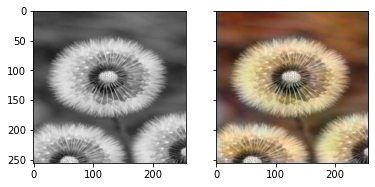

In [29]:
img = images[1]
f, arr = plt.subplots(1, 2, sharey=True)
arr[0].imshow(img.permute(1, 2, 0))
arr[1].imshow(prediction(img))